In [40]:
import copy
from kaggle_environments import make as kaggle_make
from kaggle_environments.envs.hungry_geese.hungry_geese import Action, Configuration, Observation
import matplotlib.pyplot as plt
import numpy as np
from scipy import special, stats
import torch
import torch.nn.functional as F

from hungry_geese.utils import ActionMasking
from hungry_geese.env import goose_env as ge
from hungry_geese.env.lightweight_env import LightweightEnv, make
from hungry_geese.mcts.basic_mcts import BasicMCTS

In [4]:
env = make('hungry_geese')
env.reset(num_agents=4);

In [3]:
def action_mask_func(state):
    return ActionMasking.LETHAL.get_action_mask(state)

def actor_func(state):
    return np.zeros((len(state), 4)) + 0.25
    
# Geese are evaluated based on the proportion of their length to the total length of all geese
# This value is then rescaled to account for geese that have already died
# Finally, the overall rankings and ranking estimates are rescaled to be from -1 to 1
def critic_func(state):
    n_geese = float(len(state))
    goose_lengths = np.array([len(goose) for goose in state[0]['observation']['geese']]).astype(np.float)
    dead_geese_mask = goose_lengths == 0
    agent_rankings = stats.rankdata([agent['reward'] for agent in state], method='average') - 1.
    agent_rankings_rescaled = agent_rankings / (n_geese - 1.)
    
    # Deprecated: goose_lengths_norm = goose_lengths / goose_lengths.sum()
    l_mod = state[0]['observation']['step'] / 200.
    goose_lengths_norm = special.softmax(np.where(
        dead_geese_mask,
        float('-inf'),
        goose_lengths * l_mod
    ))
    remaining_equity = n_geese / 2. - np.sum(np.arange(dead_geese_mask.sum()) / (n_geese - 1.))
    goose_lengths_norm_rescaled = goose_lengths_norm * remaining_equity
    
    final_ranks = np.where(
        dead_geese_mask,
        agent_rankings_rescaled,
        goose_lengths_norm_rescaled
    )
    if not np.isclose(final_ranks.sum(), n_geese / 2.):
        raise RuntimeError(f'Final ranks should sum to {n_geese / 2.}\n'
                           f'Final ranks: {final_ranks}\nDead geese mask: {dead_geese_mask}')
    return 2. * final_ranks - 1.
    
def terminal_value_func(state):
    agent_rankings = stats.rankdata([agent['reward'] for agent in state], method='average') - 1.
    ranks_rescaled = 2. * agent_rankings / (len(state) - 1.) - 1.
    return ranks_rescaled
    
def actor_critic_func(state):
    return actor_func(state), critic_func(state)

In [5]:
print(env.render_ansi())

search_tree = BasicMCTS(
    action_mask_func=action_mask_func,
    actor_critic_func=actor_critic_func,
    terminal_value_func=terminal_value_func,
    c_puct = np.sqrt(2.),
)
root_node = search_tree.run_mcts(
    env=env,
    n_iter=10000,
    max_time=1.
)

+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   | 3 |   |   | 0 |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | 1 |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   | F |   |   |   |   |   | 2 |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   | F |   |   |
+---+---+---+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   |   |   |   |   |
+---+---+---+---+---+---+---+---+---+---+---+



In [13]:
root_node.n_visits
root_node.q_vals

array([[-0.01133309, -0.00866546, -0.04116001,  0.00154068],
       [ 0.00330338, -0.01095515, -0.00121598,  0.01584697],
       [ 0.00630528,  0.00585535,  0.01161997, -0.0105666 ],
       [-0.01904349, -0.0149516 ,  0.00303559,  0.01530704]])

In [48]:
actions = (0, 2, 0)
q_vals = np.arange(len(actions) * 4).reshape(-1, 4)
values = np.arange(len(actions)).reshape(-1, 1) * 10
n_visits = np.arange(len(actions) * 4).reshape(-1, 4)

In [61]:
still_playing = np.array([True, False, True])

In [62]:
print(np.argmax(q_vals, axis=1))
np.where(
    still_playing,
    np.argmax(q_vals, axis=1),
    -1
)

[3 2 0]


array([ 3, -1,  0])

In [53]:
q_vals = np.where(
    np.eye(4)[np.array(actions)],
    q_vals + values,
    q_vals
)
q_vals

array([[ 0,  1,  2,  3],
       [ 4,  5, 16,  7],
       [28,  9, 10, 11]])

In [39]:
food_dists = np.array([[0, 2, 2, 2],
                       [1, 3, 3, 3],
                       [2, 2, 4, 4],
                       [3, 3, 5, 5],
                       [6, 6, 8, 8]])
special.softmax(1. / ((food_dists + 1.) * 0.4), axis=-1)

array([[0.63831411, 0.12056196, 0.12056196, 0.12056196],
       [0.38376162, 0.20541279, 0.20541279, 0.20541279],
       [0.2912851 , 0.2912851 , 0.2087149 , 0.2087149 ],
       [0.27594788, 0.27594788, 0.22405212, 0.22405212],
       [0.25991543, 0.25991543, 0.24008457, 0.24008457]])

(0.0, 1.0)

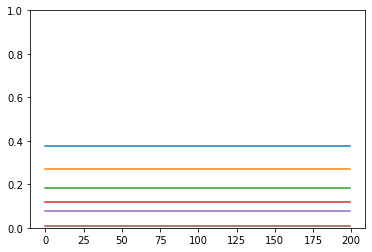

In [26]:
goose_lengths = np.array([
    [0, 1],
    [0, 2],
    [0, 3],
    [0, 4],
    [0, 5],
    [0, 10]
])
win_pcts = []
for step in range(200):
    # l_mod = step / 200.
    l_mod = 0.5 / 1.
    win_pcts.append(special.softmax(goose_lengths * l_mod, axis=-1)[:, 0])
plt.plot(win_pcts)
plt.ylim((0., 1.))